In [18]:
# !pip install -q langchain chromadb langchain-community langchain-core
# !pip install  sentence-transformers
# !pip install -U langchain-huggingface
# !pip install langchain_ollama
# !pip install pyarrow fastparquet

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
# input_path="/content/drive/My Drive/Colab Notebooks/query_ads"
input_path = "."

In [2]:
import torch
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [130]:
import sys
import gc
import os

import json
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,classification_report
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sb

import logging

from langchain_huggingface import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.memory import ConversationBufferMemory
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# from langchain_community.chat_models import ChatOllama
from langchain_ollama import ChatOllama
# from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnableConfig, RunnablePassthrough
from langchain_core.output_parsers.json import JsonOutputParser

import chromadb
from chromadb.utils import embedding_functions


#  0. Logging Configuration

In [4]:
logging.basicConfig(
    level=logging.INFO,  # You can change this to DEBUG, INFO, WARNING, ERROR, CRITICAL
    format="%(asctime)s [%(levelname)s] - %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout),  # Output to console
        logging.FileHandler(f"{input_path}/rag_llm_for_ads_evaluation.log"),  # Output to file
    ],
)
logger = logging.getLogger(__name__)  # Get the logger for this module


# 1. Read Data

## ASIN

In [5]:
df_asin = pd.read_parquet(f'{input_path}/data/esci/shopping_queries_dataset_products.parquet') \
  .query("product_locale=='us'")

In [ ]:
df_asin.head()

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color,product_locale
167168,B003O0MNGC,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,None,Virtually silent at less than 0.3 sones\nPreci...,DELTA ELECTRONICS (AMERICAS) LTD.,White,us
167169,B00MARNO5Y,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,None,Super quiet 80CFM energy efficient fan virtual...,Aero Pure,White,us
167170,B011RX6PNO,Aero Pure AP120H-SL W Slim Fit 120 CFM Bathroo...,None,"Slim Fit Housing Fits Into 2"" X 6"" Ceiling Joi...",Aero Pure,White Finish,us
167171,B01MZIK0PI,Delta Electronics (Americas) Ltd. RAD80 Delta ...,None,Quiet operation at 1.5 Sones\nPrecision engine...,DELTA ELECTRONICS (AMERICAS) LTD.,With Heater,us
167172,B01N5Y6002,Delta Electronics (Americas) Ltd. GBR80HLED De...,None,Ultra energy-efficient LED module (11-watt equ...,DELTA ELECTRONICS (AMERICAS) LTD.,"With LED Light, Dual Speed & Humidity Sensor",us


In [82]:
df_asin[df_asin["product_id"].isin(["B07DV947QN", 'B07G5XJBS9'])]

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color,product_locale
227891,B07DV947QN,Boys Mens Baseball Cross Pendant Necklace 18K ...,The necklace is a great gift for adults and ch...,"Perfect Gift for Birthday, Parties, Anniversar...",Wikavanli,A-Black,us
227895,B07G5XJBS9,"Baseball Necklace ,Men Sports Youth Baseball N...",⚾✞The cross necklace is suitable for men and m...,⚾✞【HIGH QUALITY and Unique Design 】The silver ...,SKQIR,Silver 20'',us


In [ ]:
df_asin.shape

(1215854, 7)

## Query ASIN Pair

In [6]:
df_query_asin = pd.read_parquet(f'{input_path}/data/esci/shopping_queries_dataset_examples.parquet') \
  .query("product_locale=='us'")\
  .merge(df_asin[["product_id"]], on="product_id", how="inner")

In [ ]:
df_query_asin.query("product_id=='B01N5Y6002'")

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split
15,15,revent 80 cfm,0,B01N5Y6002,us,E,0,1,train


In [ ]:
df_query_asin = df_query_asin.sort_values("query")
df_query_asin.head(50)

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split
0,0,revent 80 cfm,0,B000MOO21W,us,I,0,1,train
15,15,revent 80 cfm,0,B01N5Y6002,us,E,0,1,train
14,14,revent 80 cfm,0,B001E6DMKY,us,E,0,1,train
13,13,revent 80 cfm,0,B003O0MNGC,us,E,0,1,train
12,12,revent 80 cfm,0,B00MARNO5Y,us,E,0,1,train
10,10,revent 80 cfm,0,B011RX6PNO,us,I,0,1,train
9,9,revent 80 cfm,0,B01MZIK0PI,us,E,0,1,train
8,8,revent 80 cfm,0,B07JY1PQNT,us,E,0,1,train
11,11,revent 80 cfm,0,B00XBZFWWM,us,E,0,1,train
6,6,revent 80 cfm,0,B075ZBF9HG,us,E,0,1,train


In [106]:
df_query_asin.query("query=='#this is not a truck decals'")

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split
1610,1729,#this is not a truck decals,55,B07RTNBV6D,us,S,1,1,train
1611,1730,#this is not a truck decals,55,B07TTTLXV2,us,I,1,1,train
1612,1731,#this is not a truck decals,55,B07ZWH5QG5,us,E,1,1,train
1613,1732,#this is not a truck decals,55,B08128BBS3,us,I,1,1,train
1614,1733,#this is not a truck decals,55,B084GZB83V,us,S,1,1,train
1615,1734,#this is not a truck decals,55,B08ZSY5TJM,us,I,1,1,train
1616,1735,#this is not a truck decals,55,B084ZD9HX6,us,S,1,1,train
1617,1736,#this is not a truck decals,55,B08BNPT9XG,us,S,1,1,train
1618,1737,#this is not a truck decals,55,B08PQ6ZQCG,us,I,1,1,train
1619,1738,#this is not a truck decals,55,B08M3H3MCR,us,S,1,1,train


In [ ]:
df_query_asin.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1818825 entries, 0 to 1818824
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   example_id      1818825 non-null  int64 
 1   query           1818825 non-null  object
 2   query_id        1818825 non-null  int64 
 3   product_id      1818825 non-null  object
 4   product_locale  1818825 non-null  object
 5   esci_label      1818825 non-null  object
 6   small_version   1818825 non-null  int64 
 7   large_version   1818825 non-null  int64 
 8   split           1818825 non-null  object
dtypes: int64(4), object(5)
memory usage: 138.8+ MB


In [ ]:
df_query_asin["product_id"].nunique()

1215851

                          query esci_label  count
0                 revent 80 cfm          E     14
1                 revent 80 cfm          I      2
2  !awnmower tires without rims          C      1
3  !awnmower tires without rims          E      7
4  !awnmower tires without rims          I      5


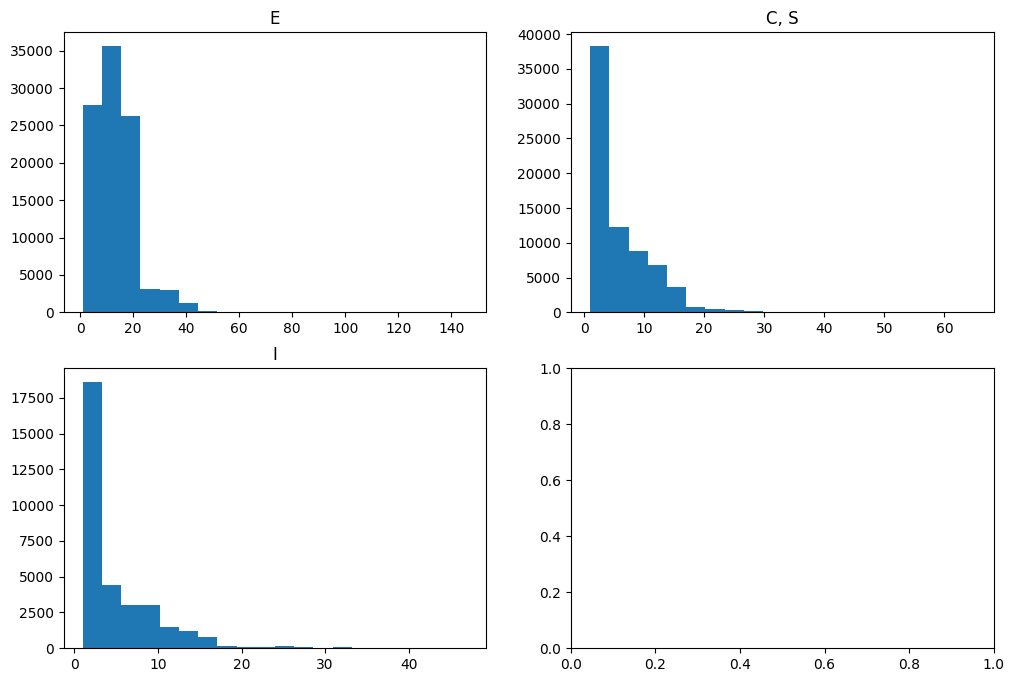

In [ ]:
df_query_asin_count_distribution = df_query_asin.groupby(["query", "esci_label"], as_index=False).agg(**{"count": ("product_id", "count")})
print(df_query_asin_count_distribution.head())
fig, axs = plt.subplots(2, 2,figsize=(12, 8))
for i, cat in enumerate([["E"], ["C", "S"], ["I"]]):
  row_idx = i // 2
  col_idx = i % 2
  ax = axs[row_idx, col_idx]
  ax.hist(df_query_asin_count_distribution.loc[df_query_asin_count_distribution.esci_label.isin(cat), ["count"]], bins=20)
  ax.set_title(f"{', '.join(cat)}")
# for one query, there are normally 5-20 E, 0-7 C or S, 0-5 I

## Archived: Extended ASIN Metadata

In [ ]:
# us_records = []
# with open(f'{input_path}/esci.json', 'r') as f:
#   for line in f:
#     stripped_line = line.strip()
#     # Skip empty lines
#     if not stripped_line:
#         continue

#     try:
#         # Parse the JSON object from the current line
#         record = json.loads(stripped_line)
#         # Check if the 'locale' key exists and its value is "us", and category does not contain books
#         category = record.get("category")
#         if record.get("locale") == "us" and isinstance(category, list) and "books" not in [i.lower() for i in category]:
#             us_records.append( #keep selected fileds only
#               {
#                 "asin": record.get("asin"),
#                 "title": record.get("title"),
#                 "description": record.get("description"),
#                 "category": record.get("category"),
#                 "attrs": record.get("attrs"),
#                 "bullets": record.get("bullets")
#               }
#             )

#     except json.JSONDecodeError as e:
#         print(f"Error decoding JSON on line: {stripped_line[:10]}... Error: {e}")
#         # Handle the error as appropriate - here we just print a message and continue
#     except Exception as e:
#         print(f"An unexpected error occurred processing line: {stripped_line[:10]}... Error: {e}")
#         # Handle other potential errors


In [ ]:
us_records[100]

{'asin': 'B08D6N2HL5',
 'title': 'HEAD Summit USA Indoor Table Tennis Table, Competition Grade Net, 10 Minute Easy Set Up – Ping Pong Table with Playback Mode - perfect for family game room, adult rec room, man cave, or garage',
 'description': 'From the manufacturer Read more Read more Deluxe Clamp On Net Set with Tension Adjustment Built-In Paddle Storage Ball Retrieving Storage Tube Clamps Under the Table to Keep the Action Going Read more Fully Laminated 15mm Warp-Resistant Surface Provides Consistent Bounce Double Chassis Frame for Simple Setup and Compact Storage Fold One Half Up for Single Player Practice Both Halves Nest Together for Low Profile Storage Read more Read more ',
 'category': ['Sports & Outdoors',
  'Sports',
  'Leisure Sports & Game Room',
  'Table Tennis',
  'Tables'],
 'attrs': {'Sport Type': 'Table Tennis',
  'Material': 'Engineered Wood, Alloy Steel',
  'Product Dimensions': '108"L x 60"W x 30"H',
  'Base Material': 'Alloy Steel',
  'Item Weight': '165.35 Poun

### Save US ASIN Metadata

In [ ]:
# output_filename = 'us_asin.json'
# try:
#     with open(f"{input_path}/{output_filename}", 'w') as f:
#         for record in us_records:
#             f.write(json.dumps(record) + '\n')
#     print(f"\nFiltered valid US records saved to '{output_filename}'")
# except IOError as e:
#     print(f"\nError saving filtered US records to file: {e}")


Filtered valid US records saved to 'us_asin.json'


In [ ]:
# del us_records

In [ ]:
# [record for record in us_records if record.get('asin')=="B0727M1B1X"]

[{'type': 'product',
  'locale': 'us',
  'asin': 'B0727M1B1X',
  'title': 'TICONDEROGA PENCILS, Wood-Cased #2 HB Soft, Pre-Sharpened with Eraser, Yellow, Six 30ct Packs/180 Count Total (X13830)',
  'stars': '4.8 out of 5 stars',
  'ratings': '360 ratings',
  'category': ['Office Products',
   'Office & School Supplies',
   'Writing & Correction Supplies',
   'Pencils',
   'Wooden Lead Pencils'],
  'attrs': {'Age Range (Description)': 'Adult',
   'Ink Color': 'Yellow',
   'Writing Instrument Form': 'Graphite Pencil',
   'Brand': 'Ticonderoga',
   'Color': 'yellow'},
  'bullets': ['Make sure this fits by entering your model number.',
   'Exclusive #2 graphite formula provides extra smooth performance',
   'Pre-sharpened to save you time',
   'Top quality, latex-free eraser provides easy, clean corrections',
   'Made with premium wood from responsibly sourced forests',
   'Satin smooth finish enhances writing comfort, PMA certified non-toxic'],
  'description': "Product Description With a

# 2. Embedding


In [7]:
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
try:
    embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)
    logger.info(f"Embedding model '{embedding_model_name}' loaded.")
except Exception as e:
    logger.error(f"Error loading embedding model: {e}")
    sys.exit(1)

2025-06-04 09:45:00,298 [INFO] - PyTorch version 2.7.0 available.
2025-06-04 09:45:00,493 [INFO] - Use pytorch device_name: mps
2025-06-04 09:45:00,494 [INFO] - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2025-06-04 09:45:03,082 [INFO] - Embedding model 'sentence-transformers/all-mpnet-base-v2' loaded.


# 4. VectorDB Setup

In [8]:
chroma_client = chromadb.PersistentClient(path=f"{input_path}/chroma_db_chunk")
chroma_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name=embedding_model_name)

try:
    chroma_collection = chroma_client.get_or_create_collection(name="ad_collection", embedding_function=chroma_ef)
    logger.info(f"ChromaDB collection created or loaded, with {chroma_collection.count()} records")
except Exception as e:
    logger.error(f"Error setting up ChromaDB: {e}")
    sys.exit(1)

2025-06-04 09:45:03,110 [INFO] - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2025-06-04 09:45:03,184 [INFO] - Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2025-06-04 09:45:17,364 [INFO] - ChromaDB collection created or loaded, with 1967340 records


## ASIN embedding

In [15]:
def add_ads_to_vectordb(ads_documents):
    """Adds the ads to the ChromaDB collection with product_id metadata."""
    ids = [ad_doc.id for ad_doc in ads_documents]
    texts = [ad_doc.page_content for ad_doc in ads_documents]
    metadatas = [ad_doc.metadata for ad_doc in ads_documents]  # Add product_id metadata
    try:
        chroma_collection.upsert(ids=ids, documents=texts, metadatas=metadatas)
        logger.info(f"Added {len(ids)} ads to ChromaDB.")
    except Exception as e:
        logger.error(f"Error adding ads to ChromaDB: {e}")
        sys.exit(1)


tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=370, # all-mpnet-base-v2 max allowed is 384
    chunk_overlap=93 #25% overlap
)

In [ ]:
chunk_size = 2000  # Adjust chunk size as needed
# len(df_asin) = 1,215,854
add_to_vectordb_complete = False
if not add_to_vectordb_complete:
    for i in range(251000, len(df_asin), chunk_size): #
    # for i in range(0, 10, 10):
# if 1== 1:
#     if 1==1:
        # df_chunk = df_asin[df_asin["product_id"].isin(["B07DV947QN", "B07G5XJBS9"])]
        df_chunk = df_asin.iloc[i:i + chunk_size]
        ads_documents_chunk = []
        new_count = 0
        for _, row in df_chunk.iterrows():
            product_id = row.get('product_id','')
            # existing_id = chroma_collection.get(ids=[product_id])['ids']
            # if existing_id:
            #     continue
            text_content = ""
            product_title = row.get('product_title')
            if pd.notna(product_title) and str(product_title).strip!='' and \
            pd.notna(product_id) and str(product_id).strip!='':
                text_content += f"""Title: {product_title}\n"""  
                new_count += 1
            else:
                continue

            text_content += f"""Description: {row.get('product_description', '')}
Bullet: {row.get('product_bullet_point', '')}
Brand: {row.get('product_brand', '')}
product_color: {row.get('product_color', '')}
"""
            # print(text_content)
            # --- CHUNKING WITH LANGCHAIN ---
            chunks = text_splitter.split_text(text_content)
            for idx, chunk in enumerate(chunks):
                ads_documents_chunk.append(
                    Document(
                        id=f"{product_id}-{idx}",
                        page_content=chunk,
                        metadata={"product_id": product_id}
                    )
                )
        
        logger.info(f"Processed ASINs {i} to {i+chunk_size}: adding {new_count} new ASINs")
        add_ads_to_vectordb(ads_documents_chunk)

## Embedding Result Glance

In [27]:
# "B07DV947QN", 'B07G5XJBS9', 
results = chroma_collection.get(
    # ids=["B07DV947QN", "B07G5XJBS9"],
    where={"product_id": {"$in": ["B07Y1YQ9YS"]}}, #
    include=['documents', 'embeddings', 'metadatas']
) #Error executing plan: Internal error: Error getting embedding

In [28]:
results

{'ids': ['B07Y1YQ9YS-0', 'B07Y1YQ9YS-1', 'B07Y1YQ9YS-2', 'B07Y1YQ9YS-3'],
 'embeddings': array([[ 0.05108738,  0.03677751, -0.01616762, ...,  0.04619268,
          0.01603331, -0.01753202],
        [ 0.03569089, -0.06036008, -0.03284853, ...,  0.02854799,
         -0.015978  , -0.00427902],
        [-0.0075906 , -0.04029364, -0.02659683, ...,  0.02666005,
          0.00943197,  0.05709381],
        [ 0.0148104 , -0.02421379, -0.00819154, ...,  0.03833184,
         -0.01146559, -0.03222566]]),
 'documents': ['Title: American Football Rugby Athletes Jersey Number 12 Stainless Steel Pendant Necklace for Boys Girls Women Men 24 Inch Chain',
  'Description: <p> <br><b>★Welcome to Rehoboth Jewelry Company!<br>We provide best service,100% satisfied sold out service.<br>We promise that we use Factual description and Real photo.Please take care about the jewelry size when you purchase. <br>Beautifully engraved Football Athletes Jersey Number Pendant Necklaces.An inspirational from Number,Nice S

In [9]:
tmp1=chroma_collection.peek(limit=2)

In [10]:
tmp1

{'ids': ['B003O0MNGC-0', 'B00MARNO5Y-0'],
 'embeddings': array([[-0.02605909, -0.00201469, -0.01862128, ...,  0.01216712,
         -0.03801715, -0.02456236],
        [-0.02470027, -0.04380682, -0.01774578, ...,  0.01578617,
         -0.00011473, -0.01775937]]),
 'documents': ['Title: Delta BreezSignature VFB25ACH 80 CFM Exhaust Bath Fan with Humidity Sensor\nDescription: None\nBullet: Virtually silent at less than 0.3 sones\nPrecision engineered with DC brushless motor for extended reliability\nEasily switch in and out of humidity sensing mode by toggling wall switch\nENERGY STAR qualified for efficient cost-saving operation\nPrecision engineered with DC brushless motor for extended reliability, this fan will outlast many household appliances\nBrand: DELTA ELECTRONICS (AMERICAS) LTD.\nproduct_color: White',
  'Title: Aero Pure AP80RVLW Super Quiet 80 CFM Recessed Fan/Light Bathroom Ventilation Fan with White Trim Ring\nDescription: None\nBullet: Super quiet 80CFM energy efficient fan v

# 3. Simulate Engaged ASINs and Filtered ASINs by Exising Relevance Model
1) Pick randomly 1K queries with >=5 "E", and >=10 "S" or "C", score all query-ASIN by vector cosine similarity.
2) Assume cosine similarity < threshold indicates "irrelevant and should be filtered"; Ask LLM to rewrite based on top E/S ASINs, rank queries by the distance btw themselves and their rewritten version, pick 1000 with the lowest distance.

## Difficult query filter 1: rule

In [50]:
# Group by query and filter
df_difficult_queries_1 = (
    df_query_asin\
    .groupby('query_id')\
    .filter(lambda x:
        len(x) >= 10 and # At least 20 different asins
        (x['esci_label'] == 'E').sum() >= 5 and # At least 3 asins with "e"
        ((x['esci_label'] == 'S') | (x['esci_label'] == 'C')).sum() >= 10 # At least 8 asins with "s" or "c"
    )
)


In [51]:
df_difficult_queries_1["query_id"].nunique()

7511

In [53]:
logger.info("Sampling query...")
r = np.random.RandomState(1234)
all_query_ids = df_difficult_queries_1["query_id"].unique()
sampled_query_ids = r.choice(all_query_ids, size=1000, replace=False)

2025-05-21 16:46:27,119 [INFO] - Sampling query...


In [54]:
df_difficult_queries_1_1k = df_difficult_queries_1[df_difficult_queries_1["query_id"].isin(sampled_query_ids)]

In [13]:
# with open(f'{input_path}/data/difficult_queries_1k_samples.pkl','wb') as f:
#     pickle.dump(df_difficult_queries_1_1k, f)
with open(f'{input_path}/data/difficult_queries_1k_samples.pkl','rb') as f:
    df_difficult_queries_1_1k = pickle.load(f)

## Difficult query filter 2: distance score

In [18]:
def product_query_cosine_similarity(query_embedding, product_id, asin_chunks):
    product_embeddings = []
    # 5. get cosine similariry score btw rewritten query and simulated_engaged_asins (mean over chunks per asin)
    for i, meta in enumerate(asin_chunks['metadatas']):
        if meta['product_id'] == product_id:
            product_embeddings.append(asin_chunks['embeddings'][i])

    if not product_embeddings:
        logger.warning(f"No embeddings found for engaged product {product_id} in pre-fetched chunks.")
        return np.nan 

    mean_product_embedding = np.mean(np.array(product_embeddings), axis=0)

    cosine_sim = cosine_similarity(
        np.array(query_embedding).reshape(1, -1),
        mean_product_embedding.reshape(1, -1)
    )[0][0]

    # for product_id in asins:
    #     doc_ids = [doc_id for doc_id in asin_chunks['ids'] if split(doc_id, '-')[0] == product_id]
    #     doc_id_index = [i for i, doc_id in enumerate(asin_chunks['ids']) if doc_id in doc_ids]

    #     cosine_sim = cosine_similarity(
    #         np.array(rewritten_query_embedding).reshape(1,-1), # 1, n_features
    #         np.mean(np.array(asin_chunks['embeddings'][doc_id_index]), axis=0) # 1, n_features
    #     )[0] # 1

    return float(cosine_sim)

In [19]:
query_embedding = embeddings.embed_query("this is not a truck decal")

In [20]:
np.array(query_embedding).reshape(1,-1).shape

(1, 768)

In [21]:
asin_embeddings = chroma_collection.get(
    where={"product_id": {"$in": ["B07ZWH5QG5","B07QPSMS91","B08W5FDHMC","B00CDVPEAA","B07HNDPWZW"]}},
    include=['embeddings','metadatas'] # Explicitly request embeddings
)

In [75]:
asin_embeddings['embeddings'].shape

(5, 384)

In [22]:
test_scores = map(lambda x: product_query_cosine_similarity(query_embedding, x, asin_embeddings)
                  , ["B07ZWH5QG5","B07QPSMS91","B08W5FDHMC","B00CDVPEAA","B07HNDPWZW"])

In [24]:
list(test_scores)

[0.6951511859236778,
 0.7298420714230854,
 0.6584749248917294,
 0.6079261147425598,
 0.6315464378458424]

In [ ]:
# Score all ASINs, such queries per vector search, and see the 'e' ASINs score distribution
# Iterate through each query_id

scored_results_file = f"{input_path}/data/difficult_queries_1_1k_scored_asins.jsonl"
nth_query=0
for query_id, group_df in df_difficult_queries_1_1k.groupby('query_id'):
    asins_for_query = (
        group_df['product_id']
        .tolist()
    )
    # print(asins_for_query)
    query = group_df["query"].iloc[0]
    query_embedding = embeddings.embed_query(query)
    
    scored_results = {
        "query": query,
        # Assuming 'query' variable contains the effective query_id or is the query text itself
        "query_id": query_id,
        "matched_products": []
    }

    logger.info(f"Performing ChromaDB search for all asins for query {nth_query}: {query}")
    asin_chunk_results = chroma_collection.get(
        where={"product_id": {"$in": asins_for_query}},
        include=['embeddings', 'metadatas'] # Explicitly request embeddings
    )

    # calculate cosine similarity score manually
    cosine_sim = list(map(lambda x: product_query_cosine_similarity(query_embedding, x, asin_chunk_results)
                  , asins_for_query))

    for i,product_id in enumerate(asins_for_query):
        scored_results["matched_products"].append({
            "product_id": product_id,
            "esci_label": group_df[group_df["product_id"]==product_id]["esci_label"].item(),
            "similarity_score": cosine_sim[i],
        })

    with open(scored_results_file, 'a') as f:
        f.write(json.dumps(scored_results) + '\n')
    logger.info(f"""Appended score for {len(scored_results['matched_products'])} ASINs for query {nth_query}: '{query}' to '{scored_results_file}'.""")
    
    
    # logger.info(f"Performing ChromaDB search for query {nth_query}: {query}")
    # try:
    #     results = chroma_collection.query(
    #         query_texts=[query],
    #         n_results=len(e_asins_for_query),
    #         ids=e_asins_for_query,
    #         # where={"souce": {"$in": sources_list}}
    #     )
    #     logger.info(f"ChromaDB search for query {nth_query} completed with {len(results['ids'][0])} ASINs.")
    #     # Process the results

    #     if results and results['ids']:
    #         for i in range(len(results['ids'][0])):
    #             result_asin = results['ids'][0][i]
    #             if result_asin in e_asins_for_query:
    #                 new_result = {
    #                     'query_id': query_id,
    #                     'query': query,
    #                     'product_id': result_asin,
    #                     'distance': results['distances'][0][i],
    #                     'document': results['documents'][0][i]
    #                 }
    #                 try:
    #                     with open(scored_results_file, 'a') as f:
    #                         f.write(json.dumps(new_result) + '\n')
    #                 except IOError as e:
    #                     logger.error(f"Error appending scored results to {scored_results_file}: {e}")
    # except Exception as e:
    #     logger.error(f"Error during ChromaDB search for query {query}: {e}")
    nth_query+=1
    # if nth_query == 2:
    #     break
    


### Distance score histogram

In [33]:
data_lines = []
with open(f"{input_path}/data/difficult_queries_1_1k_scored_asins.jsonl", 'r') as f:
    for line in f:
        data = json.loads(line)
        for product in data["matched_products"]:
            data_lines.append({
                "query": data["query"],
                # Assuming 'query' variable contains the effective query_id or is the query text itself
                "query_id": data["query_id"],
                "product_id": product["product_id"],
                "esci_label": product["esci_label"],
                "similarity_score": product["similarity_score"]
            })
            
df_difficult_queries_1_1k_score = pd.DataFrame(data_lines)
        

In [34]:
df_difficult_queries_1_1k_score.head()

,query,query_id,product_id,esci_label,similarity_score
0,#12 black boys chain necklace without baseball...,23,B07Y1YQ9YS,E,0.636943
1,#12 black boys chain necklace without baseball...,23,B07Y9Q7VW3,E,0.443220
2,#12 black boys chain necklace without baseball...,23,B07Z7S9W2J,I,0.554243
3,#12 black boys chain necklace without baseball...,23,B0814PH3ZS,S,0.670376
4,#12 black boys chain necklace without baseball...,23,B081DYNPJR,E,0.605505


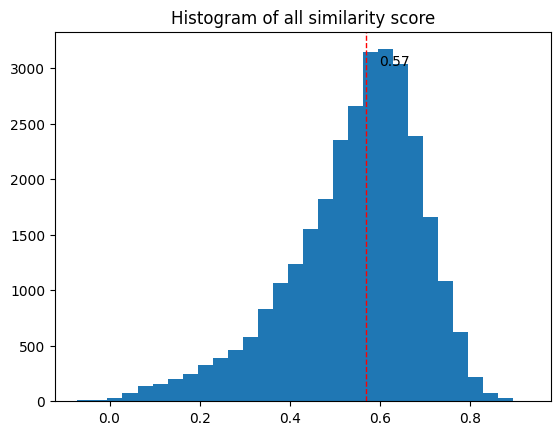

In [35]:
plt.hist(df_difficult_queries_1_1k_score["similarity_score"], bins=30)
percentile_50 = np.percentile(df_difficult_queries_1_1k_score["similarity_score"], 50)
plt.axvline(percentile_50, color='red', linestyle='dashed', linewidth=1)
plt.text(percentile_50 * 1.05, plt.ylim()[1] * 0.9, f'{percentile_50:.2f}', va='bottom', ha='left')
plt.title('Histogram of all similarity score')
plt.show()

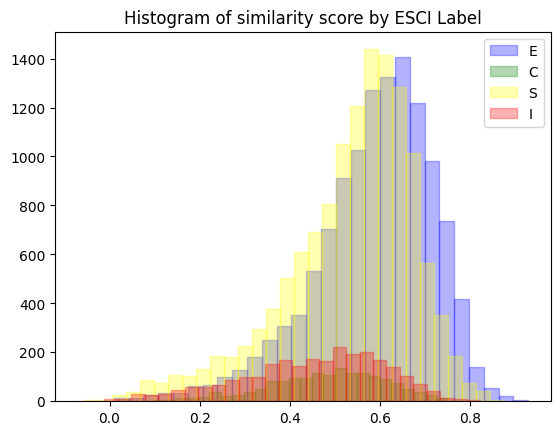

In [36]:
for cat, color in zip(["E", "C", "S", "I"], ["Blue", "Green", "Yellow", "Red"]):
    plt.hist(df_difficult_queries_1_1k_score.query(f"esci_label=='{cat}'")["similarity_score"],
             bins=30, alpha=0.3, label=cat, color=color, edgecolor=color)
plt.title('Histogram of similarity score by ESCI Label')
plt.legend()
plt.show()

In [37]:
mask_CS = df_difficult_queries_1_1k_score['esci_label'].isin(['C', 'S'])
mask_E = df_difficult_queries_1_1k_score['esci_label'] == 'E'

# Initialize an empty dictionary to store aggregated results
results = {}

grouped_CS = df_difficult_queries_1_1k_score[mask_CS].groupby('query_id')['similarity_score']
results['CS_max'] = grouped_CS.max()
results['CS_min'] = grouped_CS.min()

grouped_E = df_difficult_queries_1_1k_score[mask_E].groupby('query_id')['similarity_score']
results['E_max'] = grouped_E.max()
results['E_min'] = grouped_E.min()

results['all_max'] = df_difficult_queries_1_1k_score.groupby('query_id')['similarity_score'].max()

# Combine results into a single DataFrame
df_query_similarity_score_max_min = pd.DataFrame(results)


In [38]:
df_query_similarity_score_max_min.head()

,CS_max,CS_min,E_max,E_min,all_max
query_id,,,,,
23,0.733048,0.306342,0.703376,0.443220,0.733048
28,0.569268,0.336469,0.573927,0.339162,0.573927
40,0.663959,0.547633,0.649018,0.502472,0.663959
55,0.645252,0.505370,0.647249,0.553633,0.647249
88,0.540742,0.424003,0.660541,-0.056359,0.660541


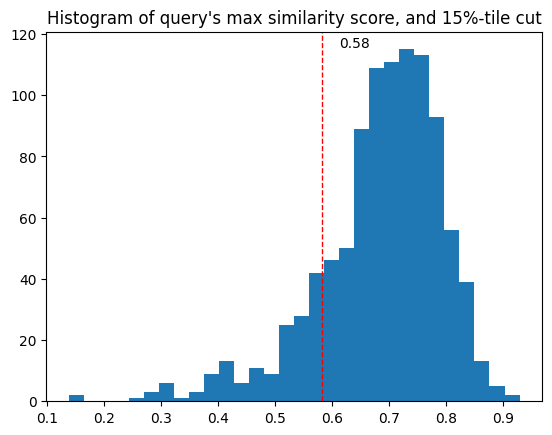

In [39]:
# if assume filtering ASINs with score<0.58, then 15% queries have no ads engagement
plt.hist(df_query_similarity_score_max_min["all_max"], bins=30)
percentile_15 = np.percentile(df_query_similarity_score_max_min["all_max"], 15)
plt.axvline(percentile_15, color='red', linestyle='dashed', linewidth=1)
plt.text(percentile_15 * 1.05, plt.ylim()[1] * 0.95, f'{percentile_15:.2f}', va='bottom', ha='left')
plt.title("Histogram of query's max similarity score, and 15%-tile cut")
plt.show()

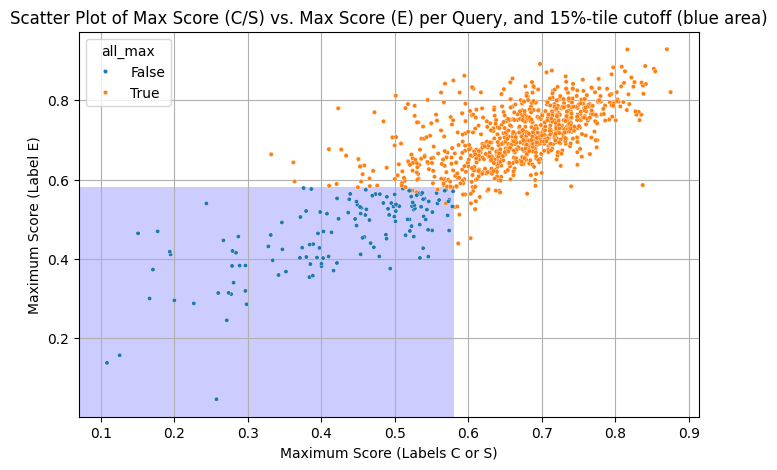

In [40]:
# in the 15% difficult queries (blue area), assume top 3 E ASINs were engaged in non-ads placements
from matplotlib.patches import Rectangle
plt.figure(figsize=(8, 5))
ax = sb.scatterplot(data=df_query_similarity_score_max_min, x='CS_max', y='E_max', 
                    hue=df_query_similarity_score_max_min["all_max"]>0.58, s=10, zorder=2)
blue_area = Rectangle((0, 0), 0.58, 0.58,
                      facecolor='blue',  # Fill color of the area
                      alpha=0.2,         # Transparency of the area (0.0 fully transparent, 1.0 fully opaque)
                      edgecolor='none',  # No border around the area
                      zorder=1)          # Draw the rectangle behind the scatter points

ax.add_patch(blue_area)
plt.title('Scatter Plot of Max Score (C/S) vs. Max Score (E) per Query, and 15%-tile cutoff (blue area)')
plt.xlabel('Maximum Score (Labels C or S)')
plt.ylabel('Maximum Score (Label E)')
plt.grid(True)
plt.show()

### Cutoff for C/S
1) Assume similarity_score < 0.57 are filtered ASINs; about 50% filter rate;
2) About 15% queries have all E and C/S ASINs scored <0.58
4) Assume top 3 E/C/S ASINs in these queries were engaged ASINs from non-Ads placements

In [41]:
df_difficult_queries_2 = df_difficult_queries_1_1k_score\
[df_difficult_queries_1_1k_score["query_id"]\
.isin(
(df_query_similarity_score_max_min.query("E_max<=0.58 and CS_max<=0.58").index)
)
].copy()

In [181]:
# df_difficult_queries_2.loc[df_difficult_queries_2['esci_label']=='E', 'score_rank'] = \
# df_difficult_queries_2[df_difficult_queries_2['esci_label']=='E']\
# .groupby('query_id')['similarity_score'].rank(method='dense', ascending=False)

In [42]:
df_difficult_queries_2.head()

,query,query_id,product_id,esci_label,similarity_score
40,#2 pencils with erasers sharpened not soft,28,B078K6FRD6,E,0.450397
41,#2 pencils with erasers sharpened not soft,28,B07G2Q28PG,E,0.573927
42,#2 pencils with erasers sharpened not soft,28,B07G2RYY6H,E,0.564809
43,#2 pencils with erasers sharpened not soft,28,B07G4DL3B5,E,0.528383
44,#2 pencils with erasers sharpened not soft,28,B07GJQJFG6,S,0.569268


# 4. Difficult Query Rewrite

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
llm = ChatOllama(
    model="mistral",
    temperature=0.3,
    um_ctx=2048,  # Larger context window
    num_thread=4
)

top_n_engaged = 3
nth_query = 0
query_rewrite_results_file = f"{input_path}/data/difficult_queries_2_rewrite_results.jsonl"

for query_id, group_df in df_difficult_queries_2.groupby('query_id'):
    query = group_df["query"].iloc[0]
    query_length = len(query)

    all_asins = group_df["product_id"].unique().tolist()
    
    # 1. define simulated engaged and filtered ASINs
    simulated_engaged_asins = group_df \
    .query("esci_label=='E'")\
    .sort_values(by="similarity_score", ascending=False) \
    .head(top_n_engaged)["product_id"] \
    .unique()\
    .tolist()
    
    logger.info(f"Performing ChromaDB search for all asins for query {nth_query}: {query}")
    asin_chunks = chroma_collection.get(
        where={"product_id": {"$in": simulated_engaged_asins}}, #all_asins}}, 
        include=['embeddings', 'documents', 'metadatas'] # Explicitly request embeddings
    )

    simulated_engaged_asin_docs = [
        doc for i, (meta, doc) in 
        enumerate(zip(asin_chunks['metadatas'], asin_chunks['documents']))
        if meta["product_id"] in simulated_engaged_asins
    ]

    logger.info(f"Returned {len(simulated_engaged_asin_docs)} similated ASIN doc chunks")

    # 2. Condense doc chunks from engaged ASINs
    condense_prompt = ChatPromptTemplate.from_template("""
        Given the shopper query: "{query}"
        Condense this product description chunk while preserving query-relevant details:
        {chunk}
        
        Respond ONLY with the condensed version (max 50 words):
    """)

    condenser_chain = condense_prompt | llm | StrOutputParser()

    config = RunnableConfig(max_concurrency=3)
    condensed_chunks = condenser_chain.batch(
        [{"query": query, "chunk": c} for c in simulated_engaged_asin_docs],
        config=config
    )
    logger.info(f"Condensed simulated engaged ASIN chunks ...")

    # 3. rewrite query based on concatenated condensed chunks
    query_rewrite_prompt = ChatPromptTemplate.from_template("""
        I have the user query: "{query}" and
        the items the user engaged with: "{top_engaged_items}",

        Please create a concise, natural-sounding shopping query that extends the original query
        with more implicit intent as indicated by the engaged items. Max 30 words in total. 
    """)
    query_rewrite_chain = query_rewrite_prompt | llm | StrOutputParser()

    rewritten_query = query_rewrite_chain.invoke({"query": query, "top_engaged_items": "\n".join(c for c in condensed_chunks)})

    df_difficult_queries_2.loc[
        df_difficult_queries_2["query_id"]==query_id
        , 'rewritten_query'] = rewritten_query
    
    with open(query_rewrite_results_file, 'a') as f:
        f.write(json.dumps({
            "query_id": query_id,
            "query": query,
            "rewritten_query": rewritten_query
        }) + '\n')
        
    logger.info(f"Query rewrite completed --->")
    logger.info(f"{rewritten_query}")

    nth_query += 1

In [100]:
df_difficult_queries_2.drop(["rewritten_query_relevance","explanation","rewritten_query_similarity_score"], axis=1)\
    .to_parquet(f"{input_path}/data/df_query_rewrite_results.parquet")


# 5. Relevance evaluate by LLM

In [54]:
import re

LLM_PARSING_ERROR_LOG_FILE = f"{input_path}/relevance_evaluation_llm_parsing_errors.log"
def log_llm_parsing_error(query_id, product_id, chunk_idx, raw_output, inferred_relevance="N/A", error_message=""):
    """Logs raw LLM output that failed to parse correctly."""
    with open(LLM_PARSING_ERROR_LOG_FILE, 'a', encoding='utf-8') as f:
        f.write(f"--- ERROR START ---\n")
        f.write(f"QueryID: {query_id}, ProductID: {product_id}, ChunkIDX: {chunk_idx}\n")
        f.write(f"Inferred Relevance (before parse attempt): {inferred_relevance}\n")
        f.write(f"Error Message: {error_message}\n")
        f.write(f"Raw LLM Output:\n{raw_output}\n")
        f.write(f"--- ERROR END ---\n\n")

DEFAULT_RELEVANCE = "No"
DEFAULT_EXPLANATION = "failed extraction from LLM raw output."

def parse_raw_llm_output(raw_llm_output_str, query_id, product_id, chunk_idx):
    """
    Parses raw LLM string output, attempts to extract relevance and explanation.

    Args:
        raw_llm_output_str (str): The raw string output from the LLM.
        query_id: Identifier for the query.
        product_id: Identifier for the product.
        chunk_idx: Index of the chunk being processed for the product.

    Returns:
        tuple: (
            str: relevance_decision ("Yes" or "No"),
            dict: final_json_obj (parsed or constructed JSON),
            bool: should_break_product_loop (True if "Yes" successfully parsed)
        )
    """
    relevance_decision = DEFAULT_RELEVANCE
    explanation = DEFAULT_EXPLANATION
    final_json_obj = {"relevance": relevance_decision, "explanation": explanation}
    should_break_product_loop = False

    # 1. Preliminary cleaning and inference from raw string
    cleaned_for_inference = raw_llm_output_str.lower().strip()
    # Remove markdown ```json ... ``` for inference if present
    match_md = re.search(r"```(?:json)?\s*([\s\S]*?)\s*```", cleaned_for_inference, re.IGNORECASE)
    if match_md:
        cleaned_for_inference = match_md.group(1).strip()
    
    inferred_yes = bool(re.search(r'"relevance"\s*:\s*"yes"', cleaned_for_inference))
    inferred_no = bool(re.search(r'"relevance"\s*:\s*"no"', cleaned_for_inference))
    
    current_inferred_relevance = "N/A"
    if inferred_yes:
        current_inferred_relevance = "Yes"
    elif inferred_no:
        current_inferred_relevance = "No"

    # 2. Attempt to fully clean and parse the JSON
    # Start with original raw string for full parsing
    cleaned_str_for_parse = raw_llm_output_str.strip()
    match_md_parse = re.search(r"```(?:json)?\s*([\s\S]*?)\s*```", cleaned_str_for_parse, re.IGNORECASE)
    if match_md_parse:
        cleaned_str_for_parse = match_md_parse.group(1).strip()
    
    # Use regex to handle unescaped quotes in the explanation field
    final_cleaned_str_for_parse = re.sub(
        r'"explanation":\s*"(.*?)"(?=\s*[},])',
        lambda m: f'"explanation": {json.dumps(m.group(1))}',
        cleaned_str_for_parse,
        flags=re.DOTALL
    )

    try:
        parsed_data = json.loads(final_cleaned_str_for_parse)
        
        # Successfully parsed JSON
        extracted_relevance = parsed_data.get("relevance", "").strip().lower()
        extracted_explanation = parsed_data.get("explanation", DEFAULT_EXPLANATION).strip()
        if extracted_explanation == DEFAULT_EXPLANATION:
            log_llm_parsing_error(query_id, product_id, chunk_idx, raw_llm_output_str,
                                  current_inferred_relevance, 
                                  f"Parsed JSON, but 'explanation' field failed")
        
        if extracted_relevance == "yes":
            relevance_decision = "Yes"
            final_json_obj = {"relevance": relevance_decision, "explanation": extracted_explanation}
            should_break_product_loop = True # Key condition: "Yes" AND successful parse
        elif extracted_relevance == "no":
            relevance_decision = "No"
            final_json_obj = {"relevance": relevance_decision, "explanation": extracted_explanation}
        else:
            # Parsed, but relevance field is not "yes" or "no" or is missing
            log_llm_parsing_error(query_id, product_id, chunk_idx, raw_llm_output_str,
                                  current_inferred_relevance, 
                                  f"Parsed JSON, but 'relevance' field was unexpected: '{parsed_data.get('relevance')}'")
            
            # Fallback to inferred relevance
            if current_inferred_relevance != "N/A":
                relevance_decision = current_inferred_relevance
            else:
                relevance_decision = extracted_relevance
            final_json_obj = {"relevance": relevance_decision, "explanation": extracted_explanation}

    except json.JSONDecodeError as e:
        # JSON parsing failed
        log_llm_parsing_error(query_id, product_id, chunk_idx, raw_llm_output_str, 
                              current_inferred_relevance, f"json.JSONDecodeError: {e}")
        
        # Use inferred relevance if "Yes" or "No" could be extracted
        if current_inferred_relevance != "N/A":
            relevance_decision = current_inferred_relevance
        # else: relevance_decision remains DEFAULT_RELEVANCE ("No")
        
        # Explanation remains DEFAULT_EXPLANATION as parsing failed
        explanation = DEFAULT_EXPLANATION 
        final_json_obj = {"relevance": relevance_decision, "explanation": explanation}
        if relevance_decision == "Yes":
            should_break_product_loop = True

    return relevance_decision, final_json_obj, should_break_product_loop

In [ ]:
nth_query = 0
relevance_evaluation_results_file = f"{input_path}/data/difficult_queries_2_relevance_evaluation_results.jsonl"

for query_id, group_df in df_difficult_queries_2.groupby('query_id'):
    query = group_df["query"].iloc[0]
    
    simulated_engaged_asins = group_df \
    .query("esci_label=='E'")\
    .sort_values(by="similarity_score", ascending=False) \
    .head(top_n_engaged)["product_id"] \
    .unique()\
    .tolist()

    other_asins = [product_id for product_id in group_df["product_id"].tolist() if product_id not in simulated_engaged_asins]

    logger.info(f"Performing ChromaDB search for non-top 3 E asins for query {nth_query}: {query}")
    asin_chunks = chroma_collection.get(
        where={"product_id": {"$in": other_asins}}, #all_asins}}, 
        include=['embeddings', 'documents', 'metadatas'] # Explicitly request embeddings
    )
    # other_asin_docs = [
    #     doc for i, (meta, doc) in 
    #     enumerate(zip(asin_chunks['metadatas'], asin_chunks['documents']))
    #     if meta["product_id"] in simulated_filtered_asins
    # ]

    rewritten_query = group_df["rewritten_query"].iloc[0]
    rewritten_query_embedding = embeddings.embed_query(rewritten_query)

    relevance_evaluation_results = {
        "query": query,
        # Assuming 'query' variable contains the effective query_id or is the query text itself
        "query_id": query_id,
        "product_relevance": []
    }
    # 4. Evaluate relevance of rewritten query and the filtered ASINs
    relevance_prompt = ChatPromptTemplate.from_template("""
        Given the user query: "{rewritten_query}", 
        assess the relevance of the following ads: "{filtered_chunk}".
        Is it relevant? (Yes/No) Provide a brief explanation.
        Respond in this exact JSON format:
        {{
            "relevance": "Yes|No",
            "explanation": "<your brief explanation>"
        }}
    """)
    relevance_chain =  relevance_prompt | llm | StrOutputParser() #JsonOutputParser()

    logger.info(f"Running LLM relevance evaluation for {len(other_asins)} ASINs ...")
    for product_id in other_asins:
        product_asin_chunks = [
            doc for i, (meta, doc) in 
            enumerate(zip(asin_chunks['metadatas'], asin_chunks['documents']))
            if meta["product_id"] == product_id
        ]

        cosine_sim = product_query_cosine_similarity(
            query_embedding=rewritten_query_embedding, 
            product_id=product_id, 
            asin_chunks=asin_chunks
        )

        product_final_relevance = DEFAULT_RELEVANCE
        product_final_explanation = DEFAULT_EXPLANATION
        
        for chunk_idx, chunk in enumerate(product_asin_chunks):
            relevance_evaluation_str = relevance_chain.invoke(
                {"rewritten_query": rewritten_query, "filtered_chunk": chunk}
            )
            relevance_decision, parsed_json_obj, should_break_product_loop = parse_raw_llm_output(relevance_evaluation_str, query_id, product_id, chunk_idx)
            
            if relevance_decision == "Yes":
                product_final_relevance = "Yes"
                if should_break_product_loop: # This means "Yes" was successfully parsed
                    break
                    
        relevance_evaluation_results["product_relevance"].append({
            "product_id": product_id,
            "llm_relevance": product_final_relevance,
            "llm_explanation": parsed_json_obj.get("explanation", DEFAULT_EXPLANATION),
            "rewrite_similarity_score": cosine_sim,
        })
            
        
    # Get cosine similarity score btw rewritten query and simulated engaged asin.
    logger.info(f"Performing ChromaDB search for top 3 E asins")
    simulated_engaged_asin_chunks = chroma_collection.get(
        where={"product_id": {"$in": simulated_engaged_asins}}, #all_asins}}, 
        include=['embeddings', 'documents', 'metadatas'] # Explicitly request embeddings
    )

    for product_id in simulated_engaged_asins:
        cosine_sim = product_query_cosine_similarity(
            query_embedding=rewritten_query_embedding, 
            product_id=product_id, 
            asin_chunks=simulated_engaged_asin_chunks
        )
        relevance_evaluation_results["product_relevance"].append({
                "product_id": product_id,
                "llm_relevance": "Yes",
                "llm_explanation": "Top 3 E",
                "rewrite_similarity_score": cosine_sim,
            })
        
    with open(relevance_evaluation_results_file, 'a') as f:
        f.write(json.dumps(relevance_evaluation_results) + '\n')
        
    nth_query += 1

In [60]:
data_lines = []
with open(f"{input_path}/data/difficult_queries_2_relevance_evaluation_results.jsonl", 'r') as f:
    i=0
    for line in f:
        data = json.loads(line)
        for product in data["product_relevance"]:
            data_lines.append({
                "query": data["query"],
                # Assuming 'query' variable contains the effective query_id or is the query text itself
                "query_id": data["query_id"],
                "product_id": product["product_id"],
                "llm_relevance": product["llm_relevance"],
                "llm_explanation": product["llm_explanation"],
                "rewrite_similarity_score": product["rewrite_similarity_score"]
            })
        i += 1
        if i==2:
            break
            
difficult_queries_2_relevance_evaluation = pd.DataFrame(data_lines)

In [94]:
difficult_queries_2_relevance_evaluation.head()

,query,query_id,product_id,llm_relevance,llm_explanation,rewrite_similarity_score
0,#2 pencils with erasers sharpened not soft,28,B078K6FRD6,Yes,"The ad offers high-quality, pre-sharpened #2 p...",0.729519
1,#2 pencils with erasers sharpened not soft,28,B07G4DL3B5,Yes,"The ad offers #2 pencils with erasers, which a...",0.749932
2,#2 pencils with erasers sharpened not soft,28,B07GJQJFG6,Yes,"The ad offers #2 pencils, which is a type ofte...",0.798894
3,#2 pencils with erasers sharpened not soft,28,B07H7MFBH7,Yes,The ad offers high-quality coloring pencils th...,0.605849
4,#2 pencils with erasers sharpened not soft,28,B07NW9N6W5,Yes,The ad for Madisi's Wood-Cased #2 HB Pencils m...,0.698860


# 5. Plot classification

In [101]:
difficult_queries_2_relevance_evaluation_merged = df_difficult_queries_2.drop(["rewritten_query_relevance","explanation","rewritten_query_similarity_score"], axis=1)\
.merge(difficult_queries_2_relevance_evaluation.drop("query",axis=1), on=["query_id", "product_id"], how="left")

In [209]:
difficult_queries_2_relevance_evaluation_merged.to_parquet("data/df_final_difficult_queries_2_rewrite_llm_evaluation_results.parquet")

In [103]:
difficult_queries_2_relevance_evaluation_merged.head(30)

,query,query_id,product_id,esci_label,similarity_score,rewritten_query,llm_relevance,llm_explanation,rewrite_similarity_score
0,#2 pencils with erasers sharpened not soft,28,B078K6FRD6,E,0.450397,"""Looking for high-quality, sharpened #2 penci...",Yes,"The ad offers high-quality, pre-sharpened #2 p...",0.729519
1,#2 pencils with erasers sharpened not soft,28,B07G2Q28PG,E,0.573927,"""Looking for high-quality, sharpened #2 penci...",Yes,Top 3 E,0.805933
2,#2 pencils with erasers sharpened not soft,28,B07G2RYY6H,E,0.564809,"""Looking for high-quality, sharpened #2 penci...",Yes,Top 3 E,0.786001
3,#2 pencils with erasers sharpened not soft,28,B07G4DL3B5,E,0.528383,"""Looking for high-quality, sharpened #2 penci...",Yes,"The ad offers #2 pencils with erasers, which a...",0.749932
4,#2 pencils with erasers sharpened not soft,28,B07GJQJFG6,S,0.569268,"""Looking for high-quality, sharpened #2 penci...",Yes,"The ad offers #2 pencils, which is a type ofte...",0.798894
5,#2 pencils with erasers sharpened not soft,28,B07H7MFBH7,S,0.336469,"""Looking for high-quality, sharpened #2 penci...",Yes,The ad offers high-quality coloring pencils th...,0.605849
6,#2 pencils with erasers sharpened not soft,28,B07NW9N6W5,E,0.488475,"""Looking for high-quality, sharpened #2 penci...",Yes,The ad for Madisi's Wood-Cased #2 HB Pencils m...,0.698860
7,#2 pencils with erasers sharpened not soft,28,B07T8K1HJG,E,0.413515,"""Looking for high-quality, sharpened #2 penci...",Yes,The ad for Ticonderoga Neon Pencils is relevan...,0.663943
8,#2 pencils with erasers sharpened not soft,28,B07ZGDX5MT,E,0.465970,"""Looking for high-quality, sharpened #2 penci...",Yes,The ad for Wood-Cased #2 HB Pencils meets the ...,0.706232
9,#2 pencils with erasers sharpened not soft,28,B094QX351C,E,0.432405,"""Looking for high-quality, sharpened #2 penci...",Yes,"The ad features #2 pencils (HB wood pencils), ...",0.639355


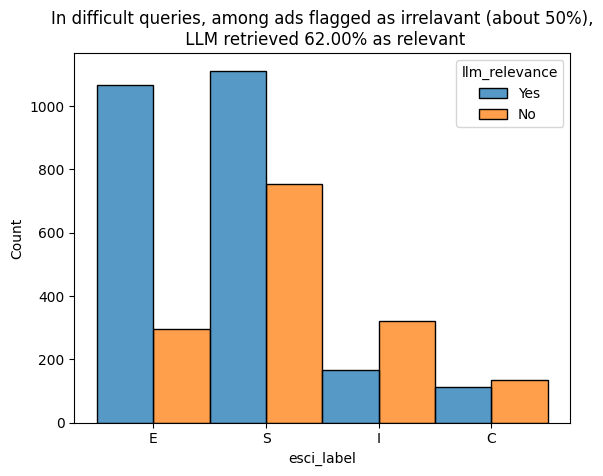

In [169]:
sb.histplot(data=difficult_queries_2_relevance_evaluation_merged, x='esci_label', hue='llm_relevance', multiple='dodge')
retrieved_rel_pct = sum(difficult_queries_2_relevance_evaluation_merged["llm_relevance"]=="Yes")/difficult_queries_2_relevance_evaluation_merged.shape[0]
plt.title(f"In difficult queries, among ads flagged as irrelavant (about 50%),\n LLM retrieved {retrieved_rel_pct*100:.2f}% as relevant")
plt.show()

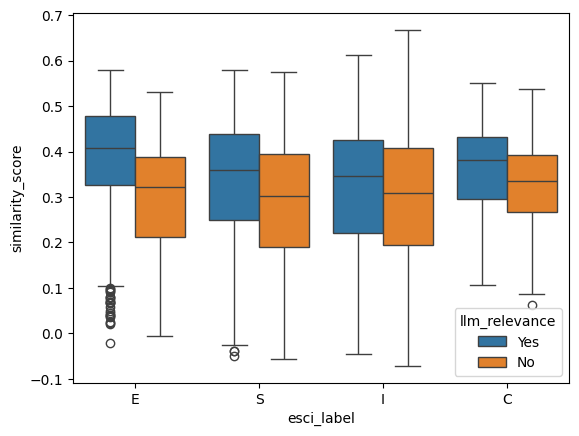

In [143]:
sns.boxplot(data=difficult_queries_2_relevance_evaluation_merged, x="esci_label", y="similarity_score", hue="llm_relevance")
plt.show()

2025-06-06 15:58:39,180 [INFO] - About 50% ads were flagged as irrelevant per universal relevance cutoff, 62.00% of them
    are determined as relevant by LLM
2025-06-06 15:58:39,181 [INFO] - We target to retrieve 30.0% among the 50%*62.00%=31.00%, 
    adding 9.30% more relevant ads
2025-06-06 15:58:39,181 [INFO] - At the same time, we control FPR at 10.0%, only adding 50%*(1-62.00%)*10.0% = 1.90% of irrelevant to the pool
    


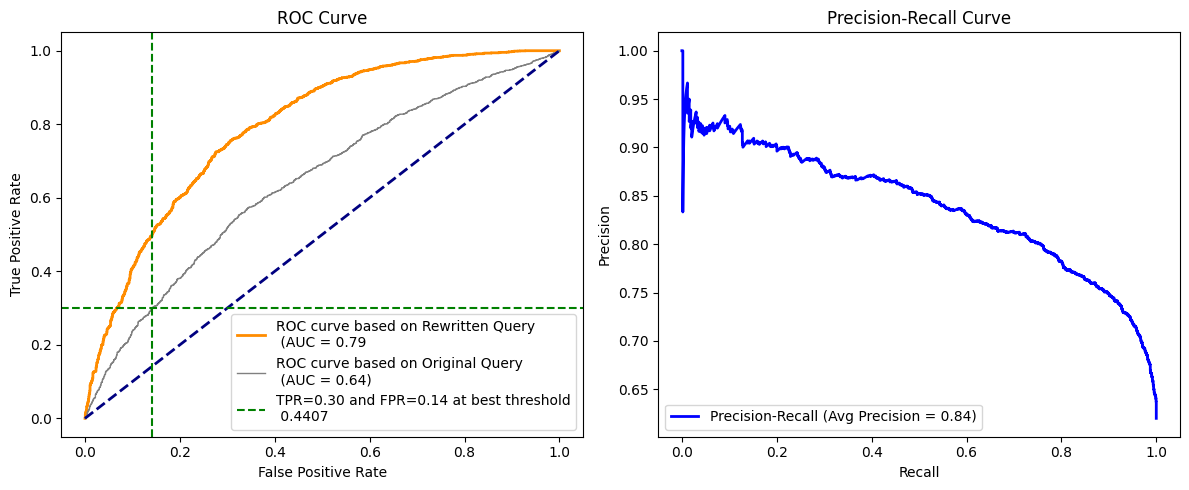

2025-06-06 15:58:39,322 [INFO] - 
Evaluation Metrics if use Cosine Similary Based on Rewritten Query:
2025-06-06 15:58:39,322 [INFO] - ROC AUC: 0.7939
2025-06-06 15:58:39,323 [INFO] - Average Precision: 0.8396
2025-06-06 15:58:39,323 [INFO] - Optimal F1 Score: 0.8205 at threshold: 0.4275
2025-06-06 15:58:39,323 [INFO] - 
Evaluation Metrics if use Cosine Similary Based on Origianl Query:
2025-06-06 15:58:39,324 [INFO] - ROC AUC: 0.6434
2025-06-06 15:58:39,324 [INFO] - At threshold: 0.4407, increased False Positive Rate 


In [175]:
y_true = np.array([1 if relevance=="Yes" else 0 for relevance in difficult_queries_2_relevance_evaluation_merged["llm_relevance"]])
y_scores = np.array(difficult_queries_2_relevance_evaluation_merged["rewrite_similarity_score"].values)
y_scores2 = np.array(difficult_queries_2_relevance_evaluation_merged["similarity_score"].values)
if len(np.unique(y_true)) > 1:
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall Curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)
    
    # Find optimal threshold (maximizing F1)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_f1_idx = np.argmax(f1_scores)
    best_threshold = pr_thresholds[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]


    # repeat for original simialrity_score
    fpr2, tpr2, thresholds2 = roc_curve(y_true, y_scores2)
    roc_auc2 = auc(fpr2, tpr2)
    precision2, recall2, pr_thresholds2 = precision_recall_curve(y_true, y_scores2)
    avg_precision2 = average_precision_score(y_true, y_scores2)

    desired_tpr2 = 0.3 
    desired_fpr2 = 0.1
    logger.info(f"""About 50% ads were flagged as irrelevant per universal relevance cutoff, {retrieved_rel_pct*100:.2f}% of them
    are determined as relevant by LLM""")
    logger.info(f"""We target to retrieve {desired_tpr2*100:.1f}% among the 50%*{retrieved_rel_pct*100:.2f}%={0.5*retrieved_rel_pct*100:.2f}%, 
    adding {0.5*retrieved_rel_pct*desired_tpr2*100:.2f}% more relevant ads""")
    logger.info(f"""At the same time, we control FPR at {desired_fpr2*100:.1f}%, only adding 50%*(1-{retrieved_rel_pct*100:.2f}%)*{desired_fpr2*100:.1f}% = {0.5*(1-retrieved_rel_pct)*desired_fpr2*100:.2f}% of irrelevant to the pool
    """)
    best_threshold_idx2 = np.argmin(np.abs(tpr2 - desired_tpr2) + np.abs(fpr2 - desired_fpr2))
    best_threshold2 = thresholds2[best_threshold_idx2]
    
    # Plot both curves
    plt.figure(figsize=(12, 5))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve based on Rewritten Query\n (AUC = {roc_auc:.2f}')
    plt.plot(fpr2, tpr2, color="gray", lw=1, label=f'ROC curve based on Original Query\n (AUC = {roc_auc2:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axvline(x=fpr2[best_threshold_idx2], color='green', linestyle='--', label=f'TPR={tpr2[best_threshold_idx2]:.2f} and FPR={fpr2[best_threshold_idx2]:.2f} at best threshold\n {best_threshold2:.4f}')
    plt.axhline(y=tpr2[best_threshold_idx2], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Precision-Recall (Avg Precision = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    logger.info(f"\nEvaluation Metrics if use Cosine Similary Based on Rewritten Query:")
    logger.info(f"ROC AUC: {roc_auc:.4f}")
    logger.info(f"Average Precision: {avg_precision:.4f}")
    logger.info(f"Optimal F1 Score: {best_f1:.4f} at threshold: {best_threshold:.4f}")
    logger.info(f"\nEvaluation Metrics if use Cosine Similary Based on Origianl Query:")
    logger.info(f"ROC AUC: {roc_auc2:.4f}")
    logger.info(f"At threshold: {best_threshold2:.4f}, increased False Positive Rate ")
    
    # Additional metrics by label type
    # for label in ['Yes', 'No']:
    #     mask = difficult_queries_2_relevance_evaluation_merged['llm_relevance'] == label
    #     if sum(mask) > 0:
    #         y_true_label = y_true[mask]
    #         y_scores_label = y_scores[mask]
    #         if len(np.unique(y_true_label)) > 1:
    #             logger.info(f"\nMetrics for label {label}:")
    #             logger.info(f"  Mean score: {np.mean(y_scores_label):.4f}")
    #             logger.info(f"  Precision: {np.mean(y_true_label):.4f}")
    #             logger.info(f"  Count: {len(y_scores_label)}")


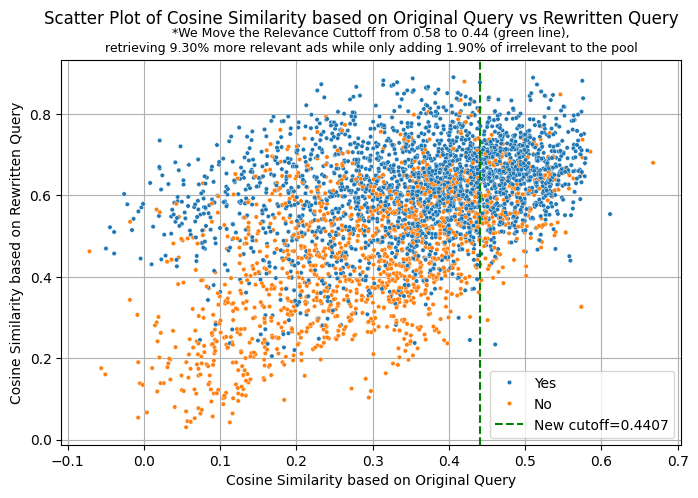

In [208]:
plt.figure(figsize=(8, 5))
ax = sb.scatterplot(data=difficult_queries_2_relevance_evaluation_merged, x='similarity_score', y='rewrite_similarity_score', 
                    hue=difficult_queries_2_relevance_evaluation_merged["llm_relevance"], s=10, zorder=2)
# plot a linear fit
# x = difficult_queries_2_relevance_evaluation_merged['similarity_score']
# y = difficult_queries_2_relevance_evaluation_merged['rewrite_similarity_score']
# m, b = np.polyfit(x,y,1)
# x_line = np.linspace(min(x), max(x), 100)
# y_line = m * x_line + b
# # y_target = 0.4275
# # x_target = (y_target-b)/m
# x_target = 0.4407

# plt.plot(x_line, y_line, color='black', label=f'Linear Regression: y = {m:.2f}x + {b:.2f}')
# Mark the point (x=10, y_target) on the plot

plt.axvline(x=x_target, color='green', linestyle='--', label=f'New cutoff={x_target:.4f}')

# plt.rc('text', usetex=True)
subtitle = f"""*We Move the Relevance Cuttoff from 0.58 to {best_threshold2:.2f} (green line),\n retrieving {0.5*retrieved_rel_pct*desired_tpr2*100:.2f}% more relevant ads while only adding {0.5*(1-retrieved_rel_pct)*desired_fpr2*100:.2f}% of irrelevant to the pool """
# subtitle = f"""xx"""
# plt.title(r'\fontsize{30pt}{3em}\selectfont{}{Scatter Plot of Cosine Similarity based on Original Query vs Rewritten Query\r}{\fontsize{18pt}{3em}\selectfont{}'+subtitle+'}')

plt.suptitle("Scatter Plot of Cosine Similarity based on Original Query vs Rewritten Query\n\n", fontsize=12)
plt.title(subtitle, fontsize=9)

plt.xlabel('Cosine Similarity based on Original Query')
plt.ylabel('Cosine Similarity based on Rewritten Query')
plt.grid(True)
plt.legend()
plt.show()

# Archive